## Objective
Become acquainted with recording objects and using them for training and testing DL model

## Imports

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Reload a module after changes have been made
from importlib import reload
# endregion

# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils import random_seed
from src import data, meta, plot

## Load and format one recording

In [ ]:
from spikeinterface import load_extractor
from spikeinterface.extractors import BinaryRecordingExtractor

In [3]:
MOUSE_PATH = meta.SI_MOUSE_PATHS[0]
##
recording_si = load_extractor(MOUSE_PATH / "spike_band.si")  # type: BinaryRecordingExtractor
# np.save(MOUSE_PATH / "recording.npy", recording_si.get_traces(return_scaled=False).T)

In [ ]:
# Format all SI mouse recordings
# from tdqm import tqdm
# for mouse_path in tqdm(meta.SI_MOUSE_PATHS[1:]):
#     recording_si = load_extractor(mouse_path / "spike_band.si")
#     np.save(mouse_path / "recording.npy", recording_si.get_traces(return_scaled=False).T)
#     # (mouse_path / "spikesort_matlab4/spike_band_scaled_filtered.dat").unlink()

## Load WaveformDataset

In [3]:
wf_dataset = data.WaveformDataset(meta.SI_MOUSE[2], 19, np.inf)

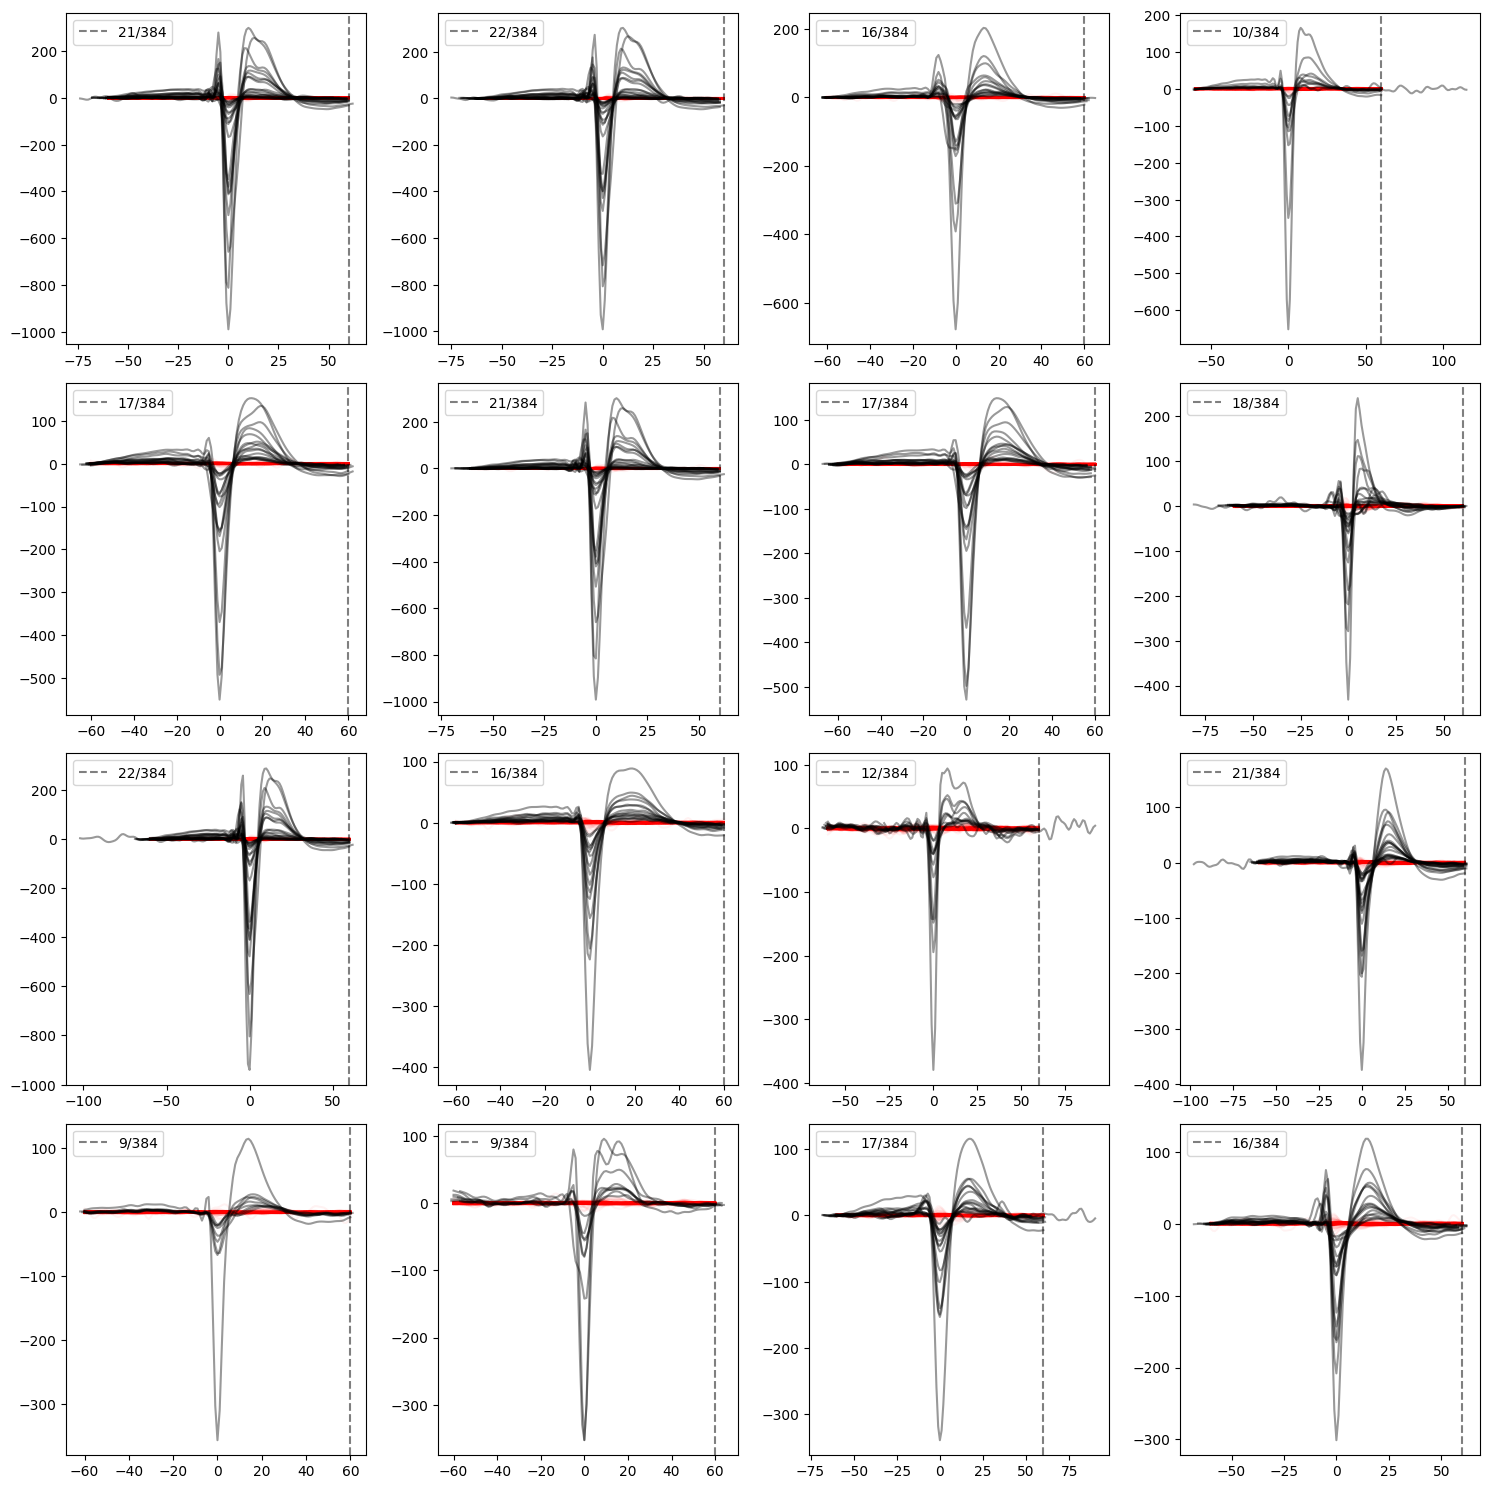

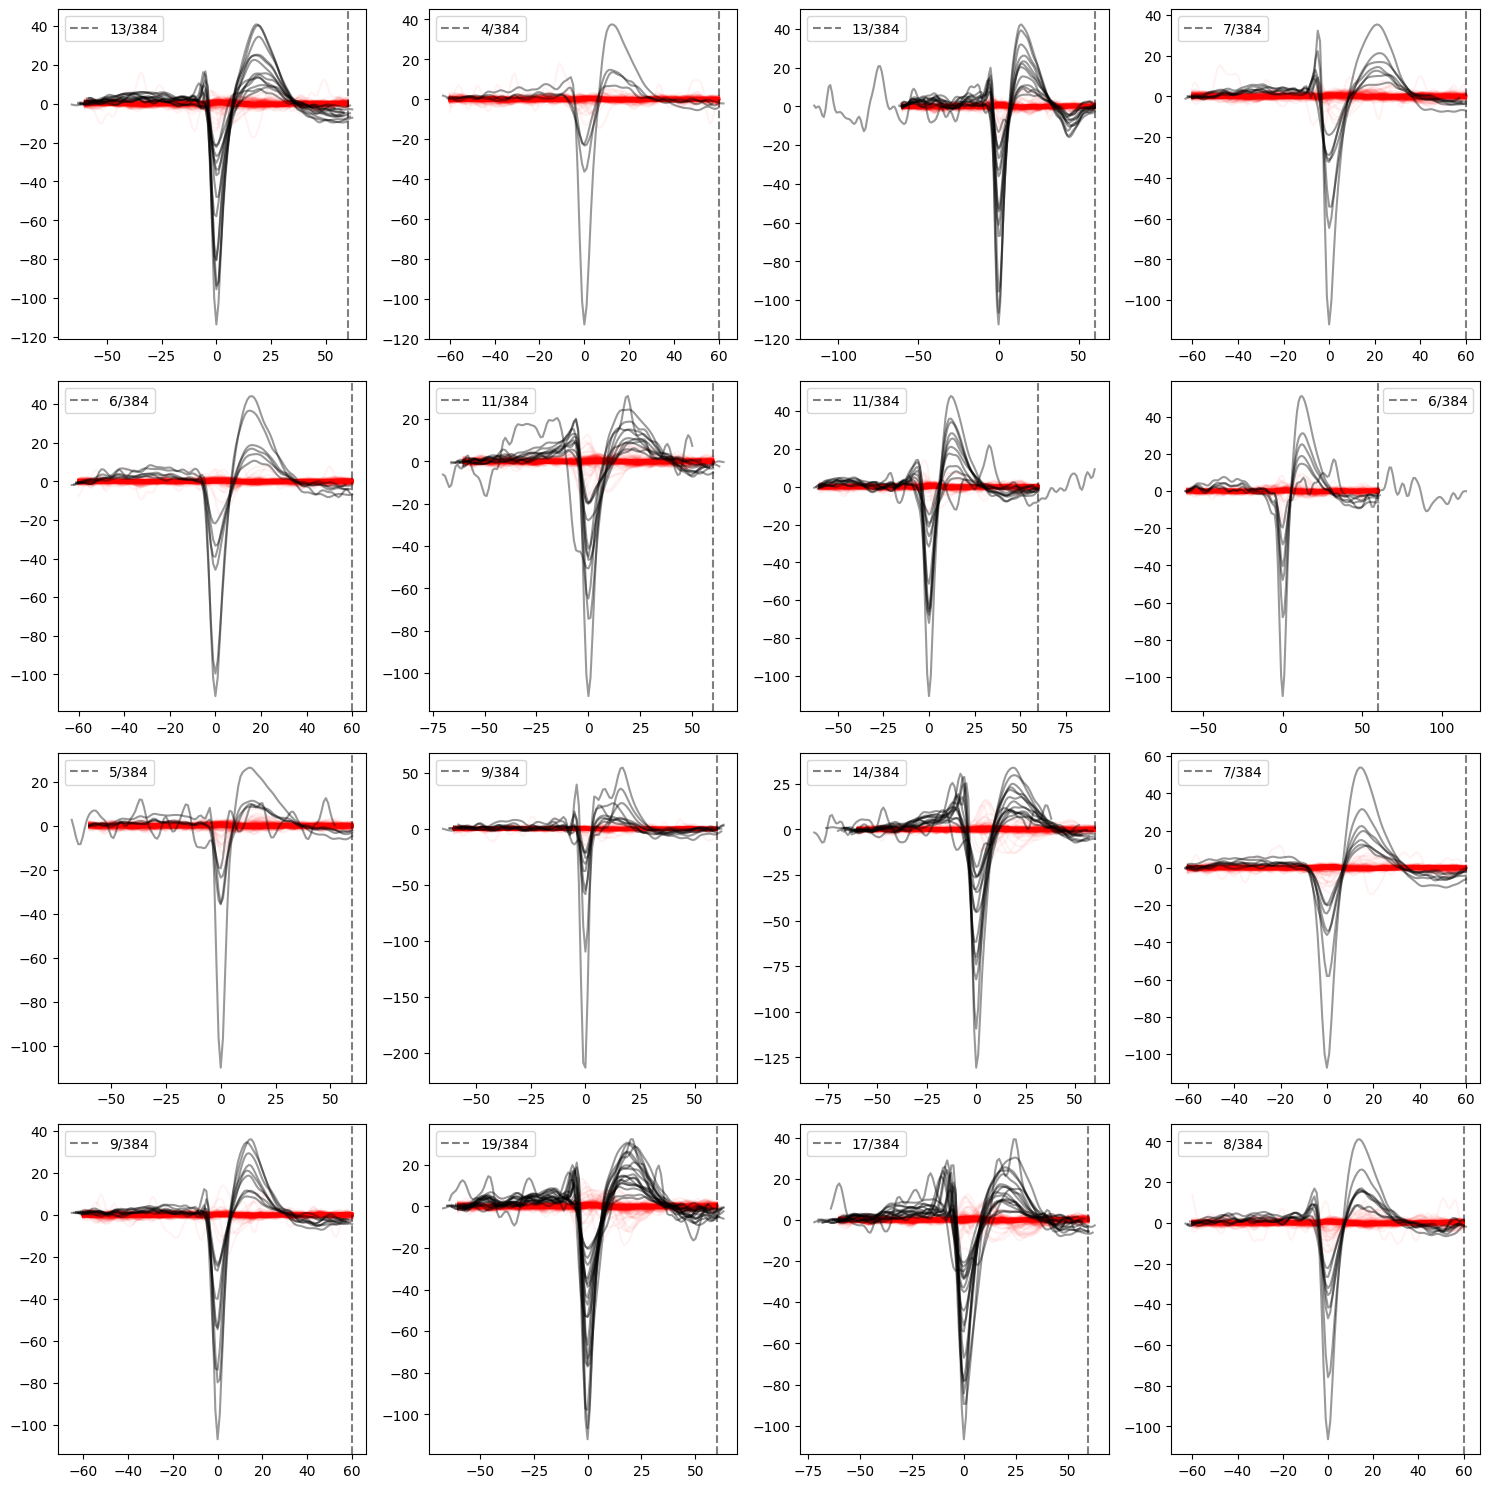

KeyboardInterrupt: 

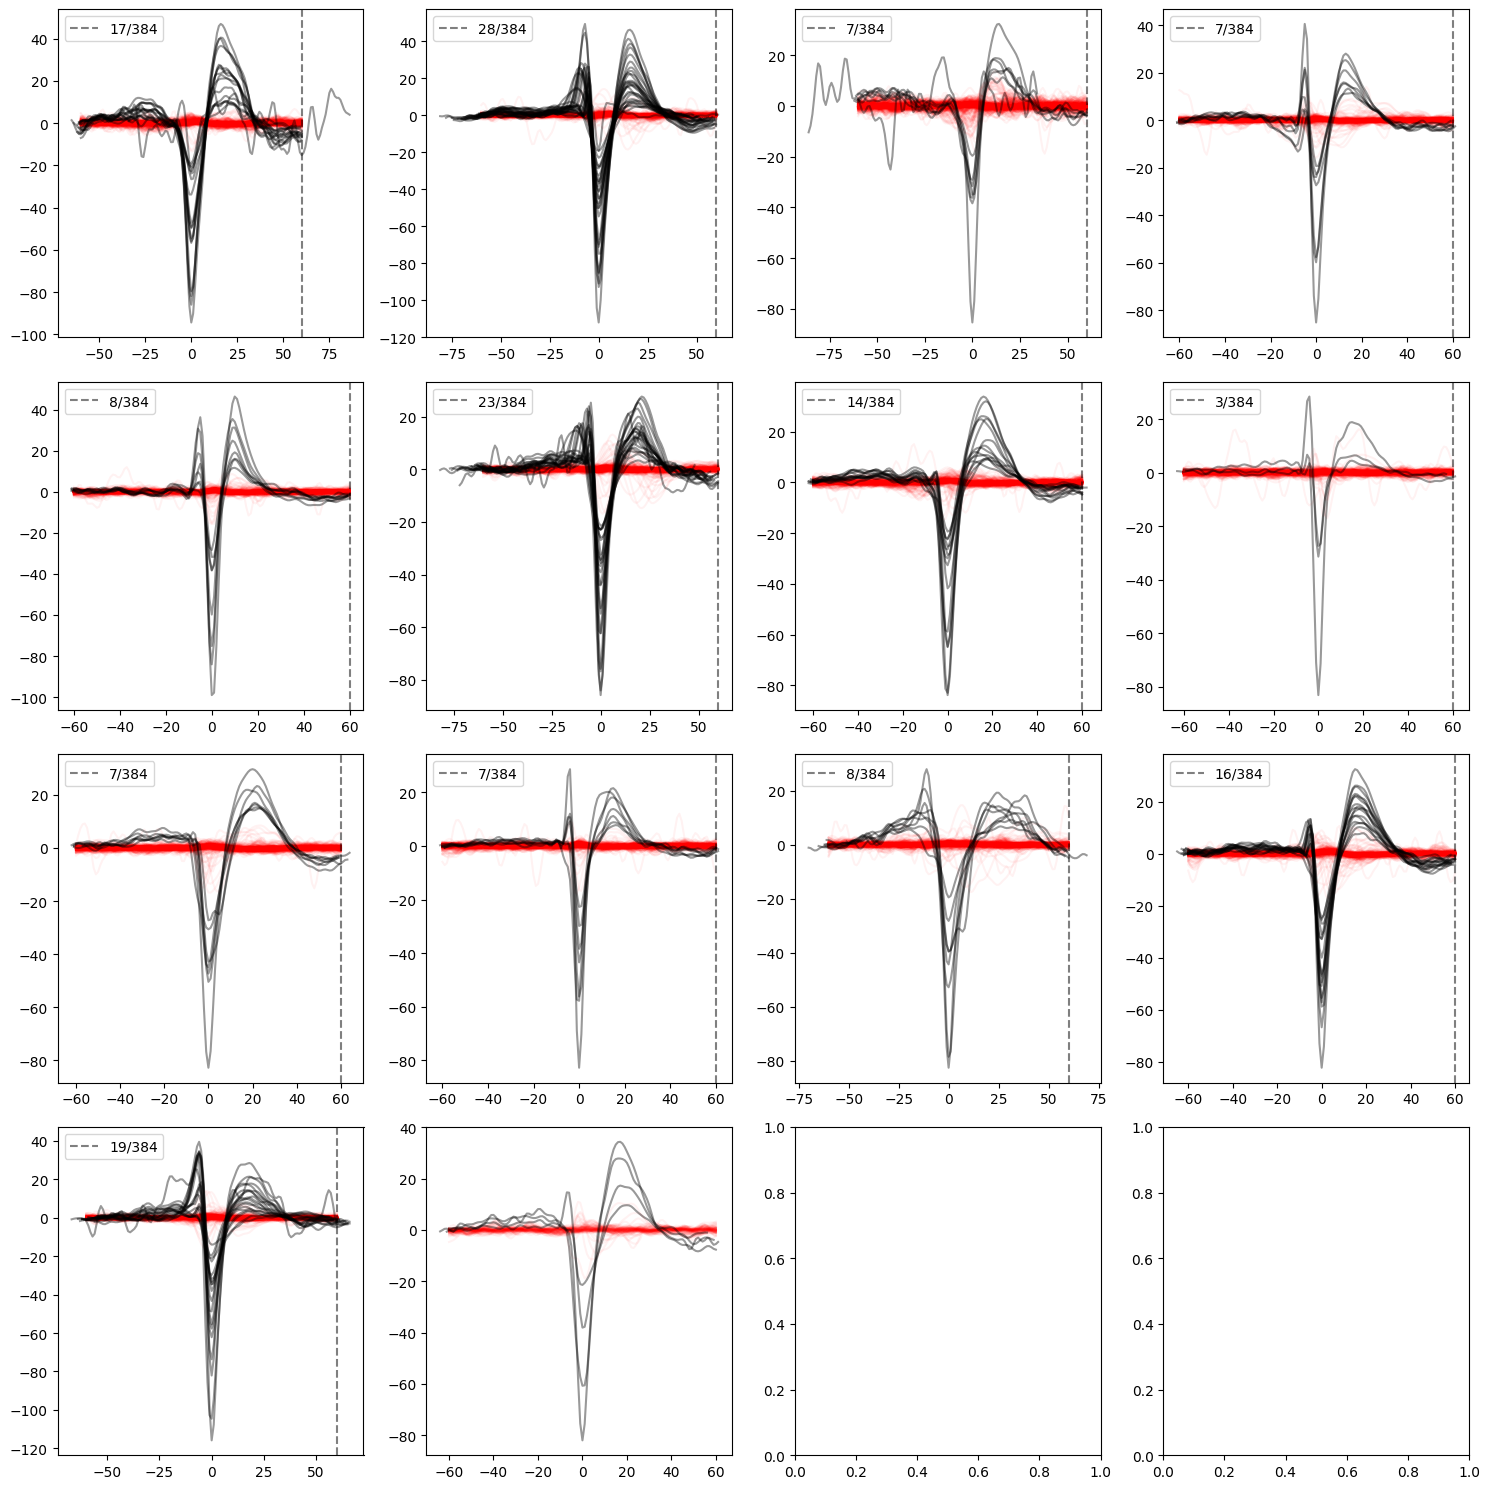

In [5]:
from src.plot import set_dpi
set_dpi(100)
wf_dataset.plot_waveforms(max_plots=[0, 8, 12])

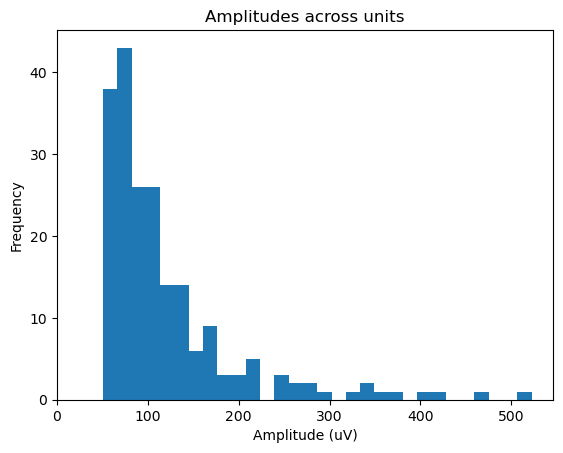

119.12657
92.97827


In [4]:
# Plot distribution of amplitudes across units
amplitudes = []
for unit in wf_dataset.units:
    amp = -1
    for wf in unit.wfs:
        amp = max(wf.alpha, amp)
    amplitudes.append(amp)

plt.title("Amplitudes across units")
plt.hist(amplitudes, bins=30)
plt.xlim(0)
plt.xlabel("Amplitude (uV)")
plt.ylabel("Frequency")
plt.show()

print(np.mean(amplitudes))
print(np.median(amplitudes))

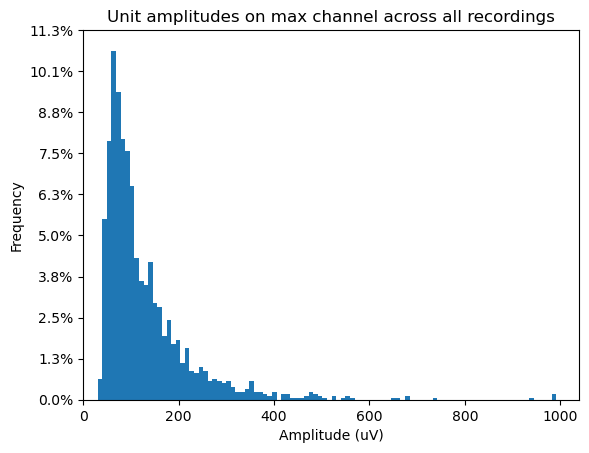

129.5227
97.73178


In [10]:
# Plot distribution of amplitudes across all recordings
amplitudes = []
for path in meta.SI_MOUSE[:]:
    wf_dataset = data.WaveformDataset(path, 0, 99999)
    for unit in wf_dataset.units:
        amp = -1
        for wf in unit.wfs:
            amp = max(wf.alpha, amp)
        amplitudes.append(amp)


fig, ax = plt.subplots()

ax.set_title("Unit amplitudes on max channel across all recordings")
plot.plot_hist_percents(amplitudes, ax, bins=100)
ax.set_xlim(0)
ax.set_xlabel("Amplitude (uV)")
ax.set_ylabel("Frequency")
plt.show()

print(np.mean(amplitudes))
print(np.median(amplitudes))

## Load MultiRecordingDataset

In [18]:
multi_rec = data.MultiRecordingDataset(
    samples_per_waveform=2, front_buffer=60, end_buffer=60,
    num_wfs_probs=None, isi_wf_min=6, isi_wf_max=None,
    rec_paths=meta.SI_MOUSE[:2], thresh_amp=19, thresh_std=9999,
    sample_size=300, start=0, ms_before=3, ms_after=3, gain_to_uv=0.195,
    device="cpu", dtype=torch.float16, mmap_mode="r"
)

Using random seed 7


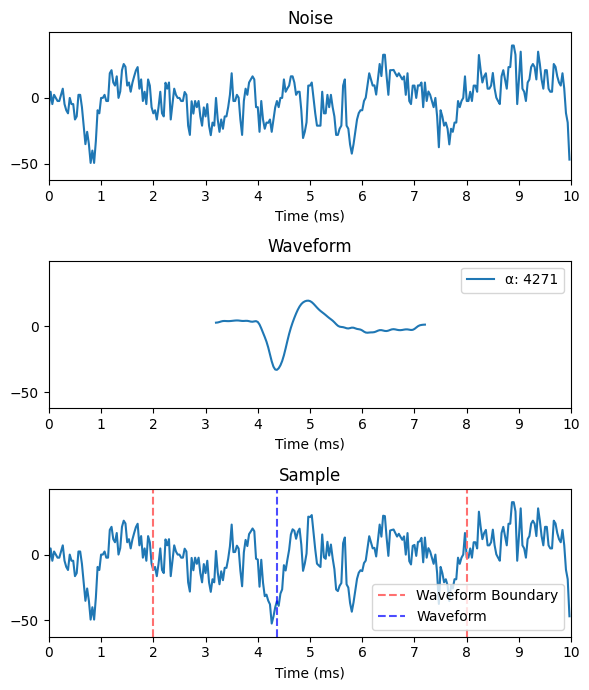

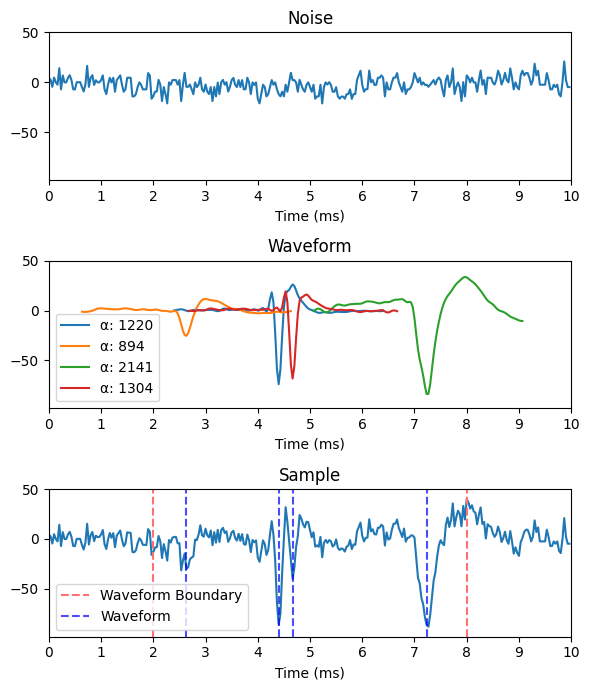

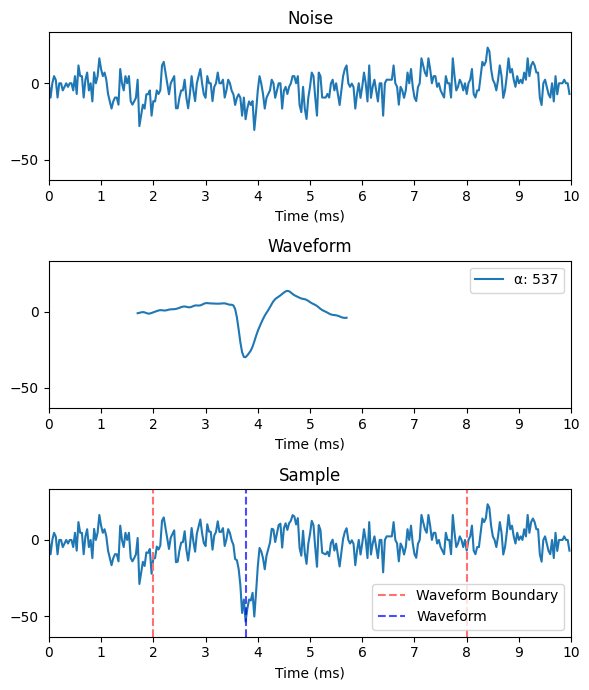

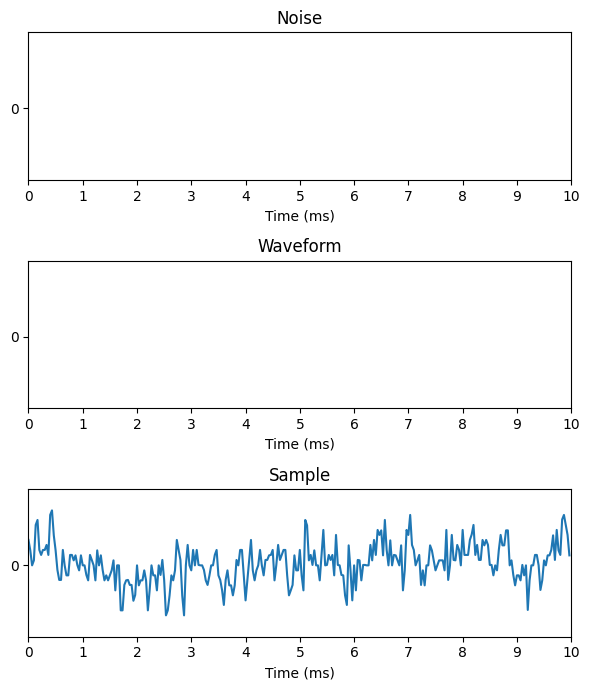

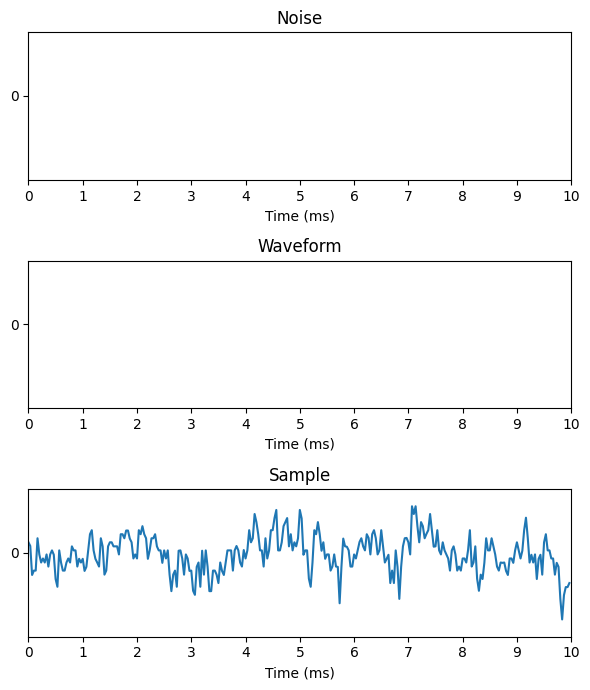

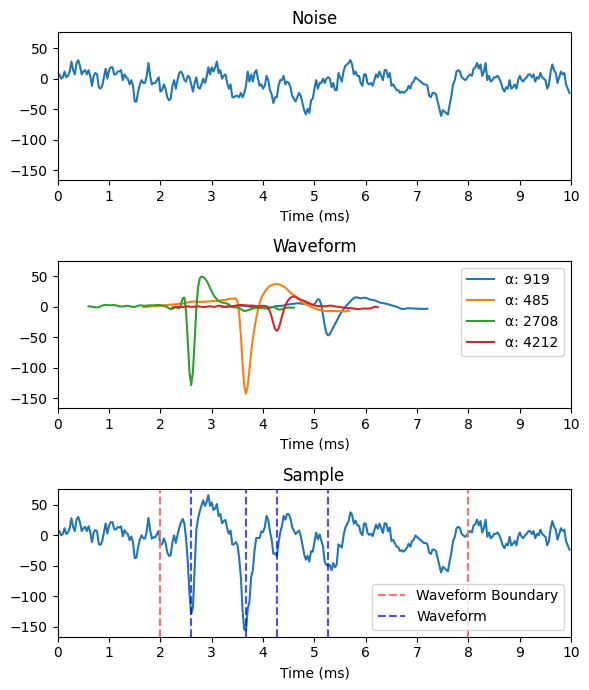

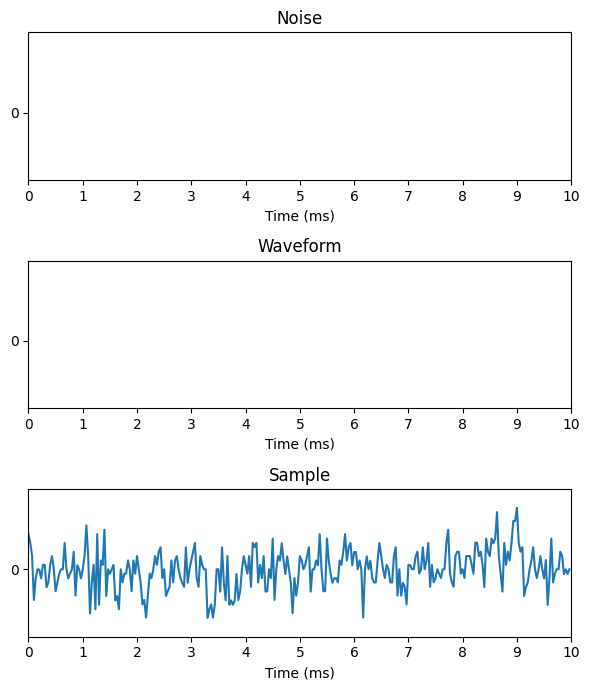

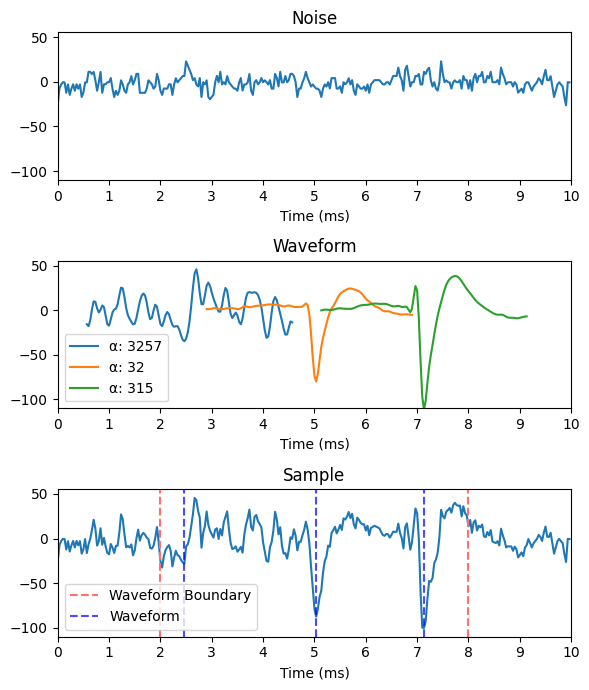

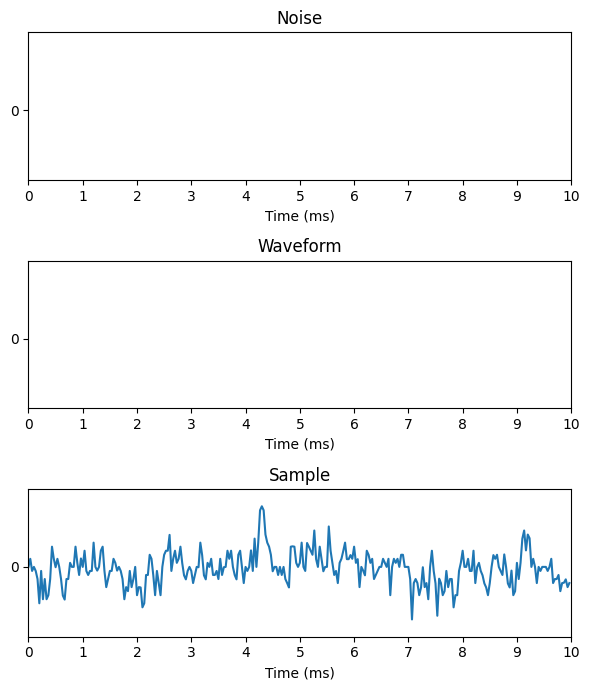

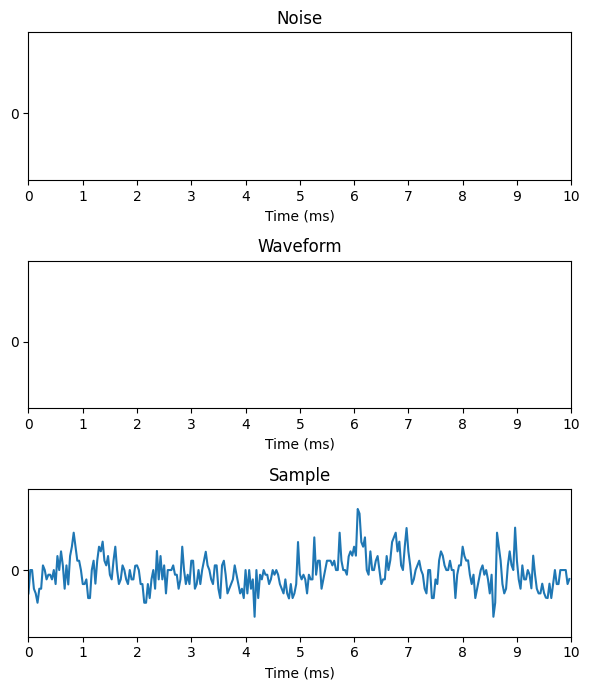

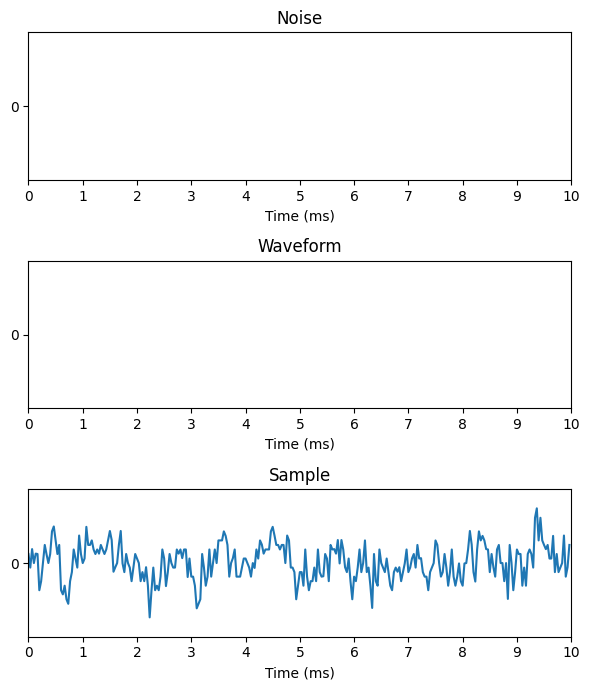

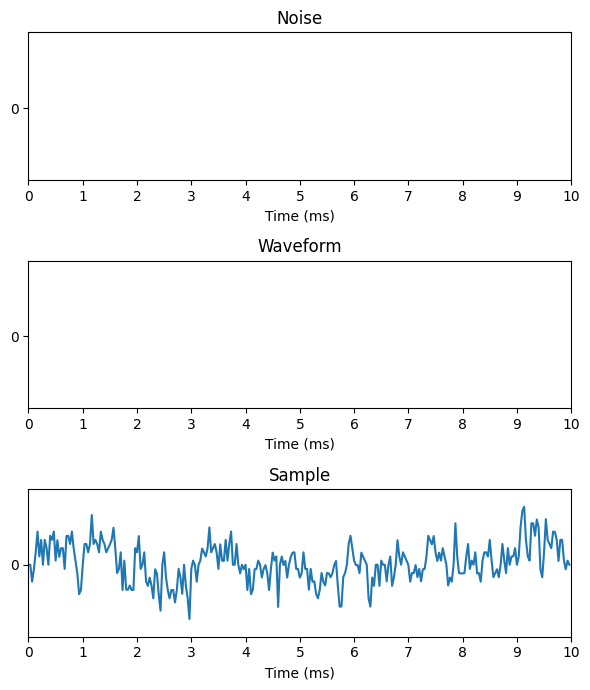

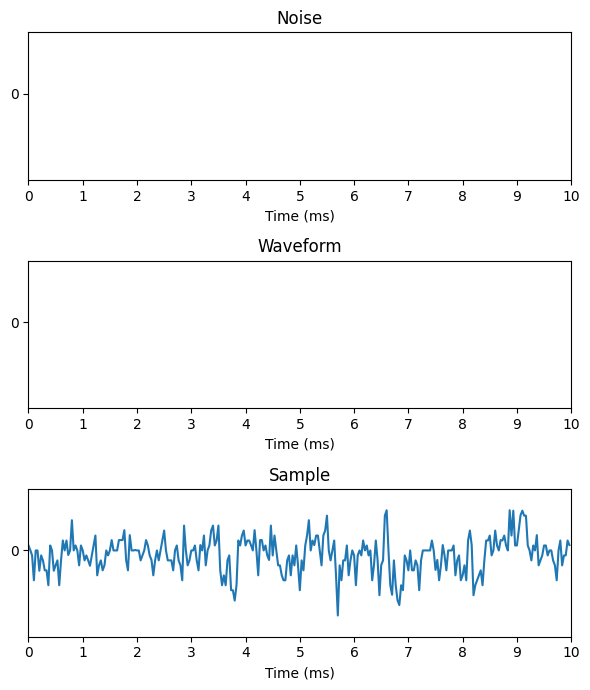

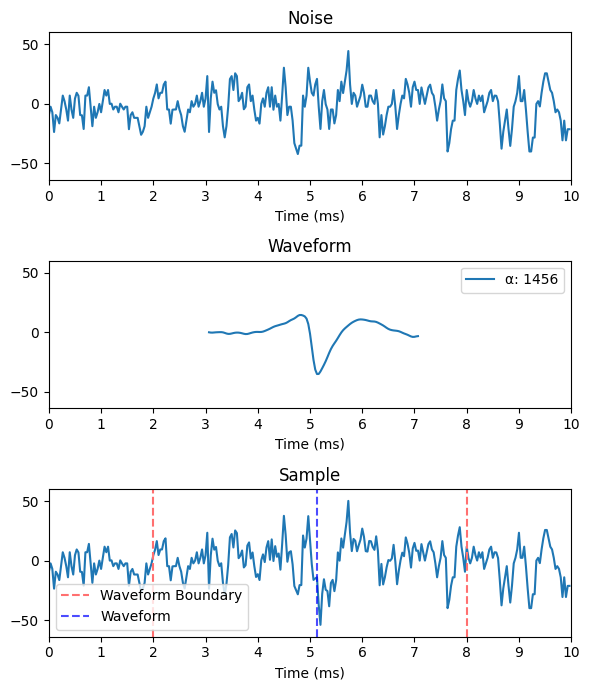

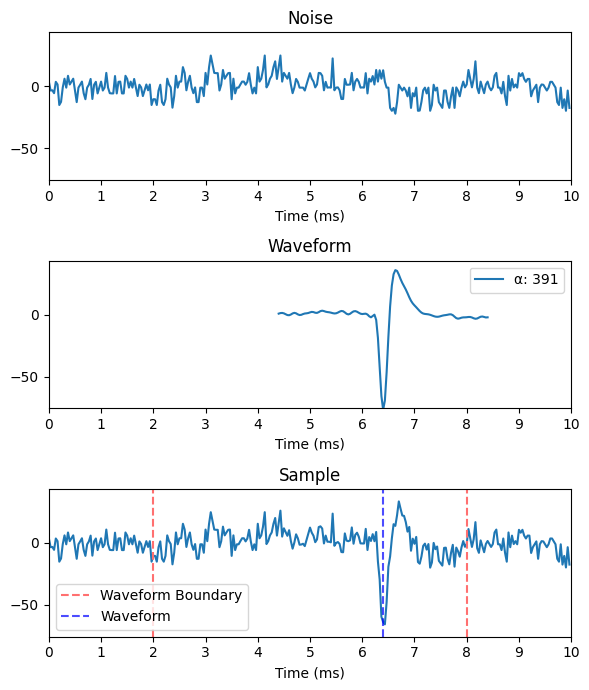

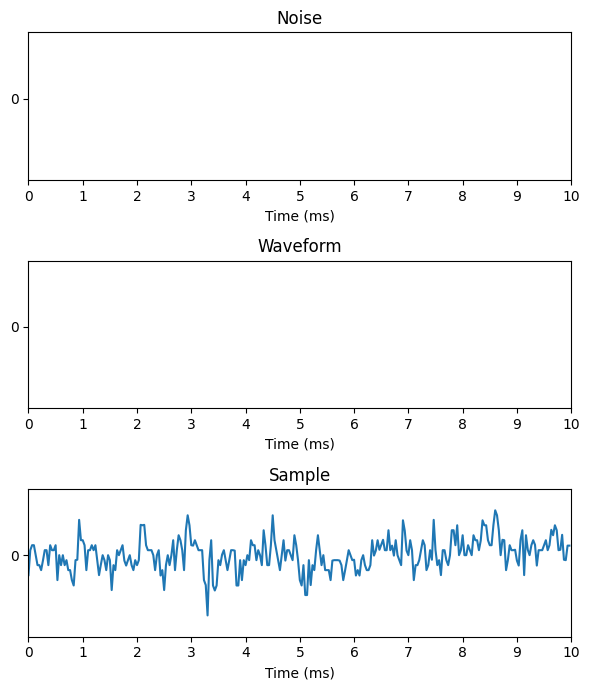

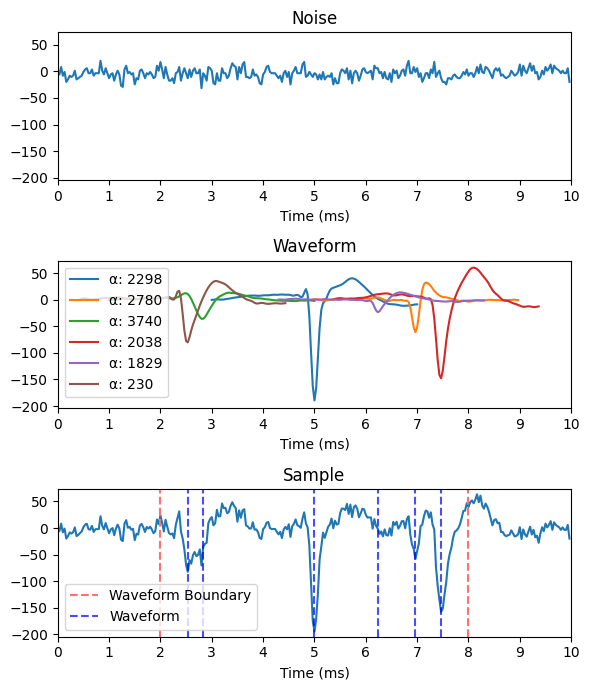

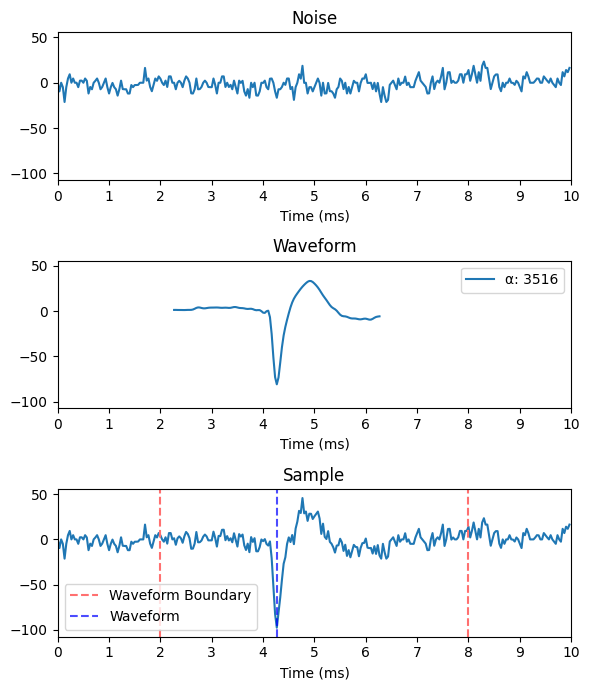

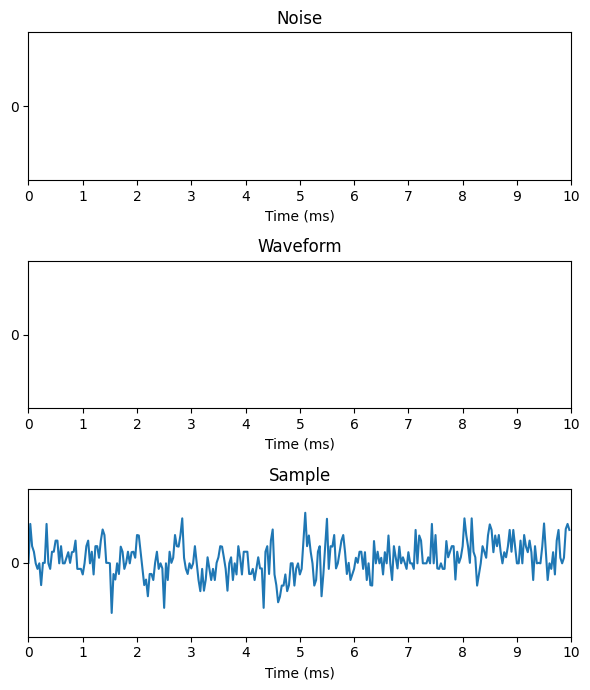

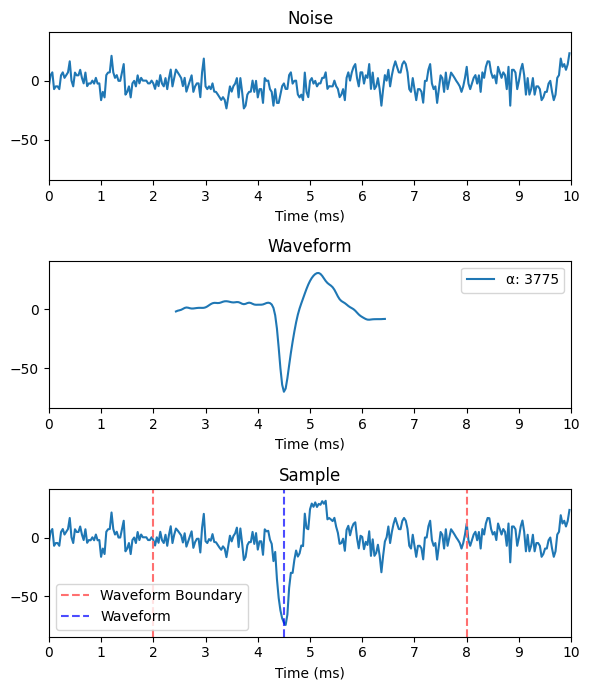

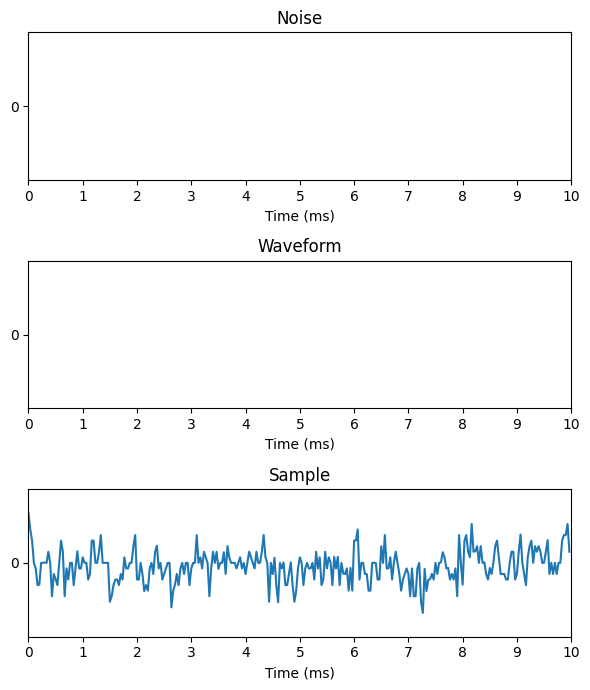

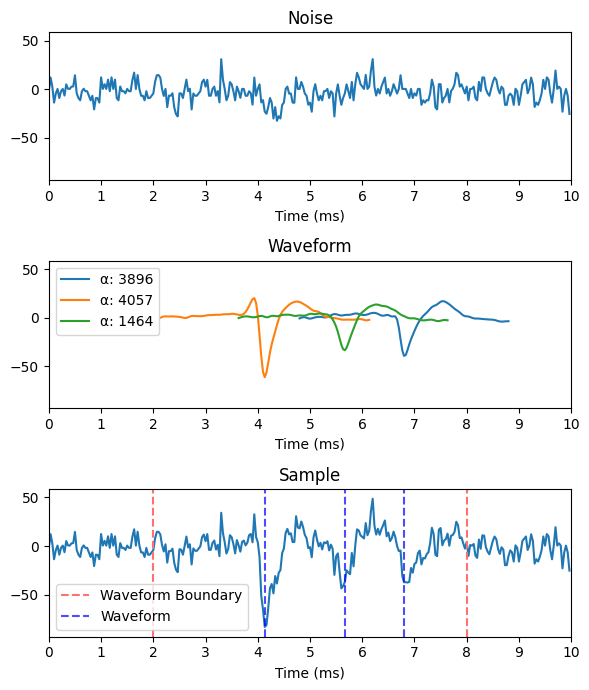

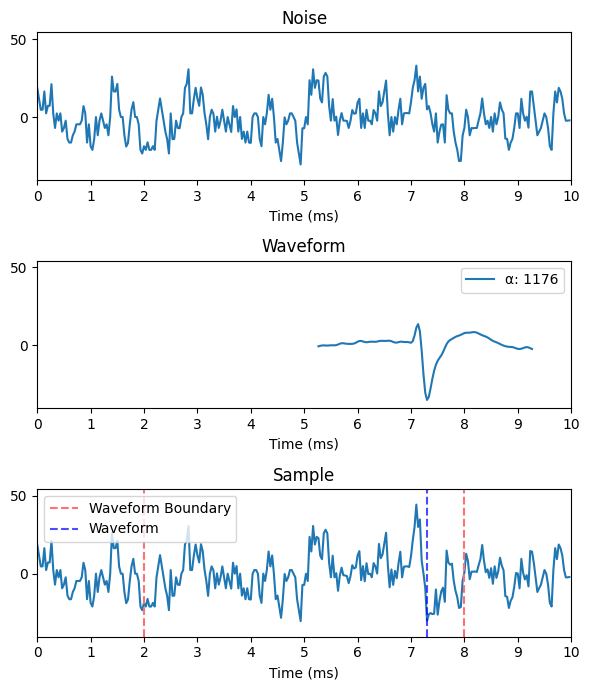

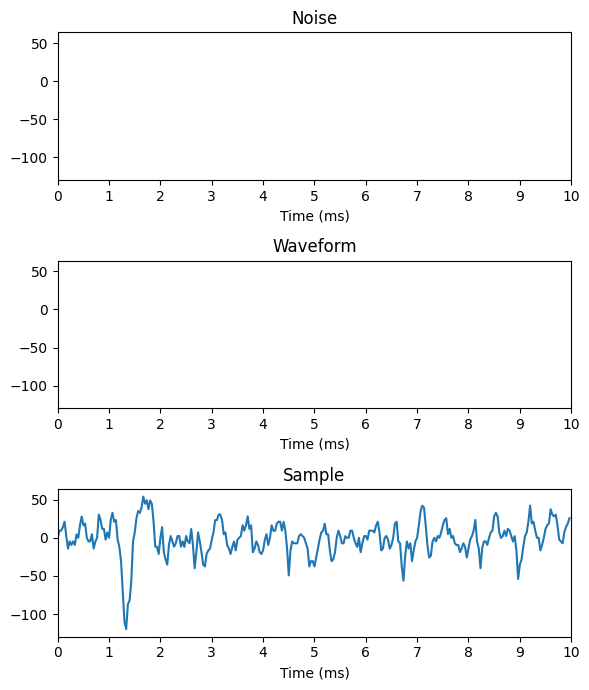

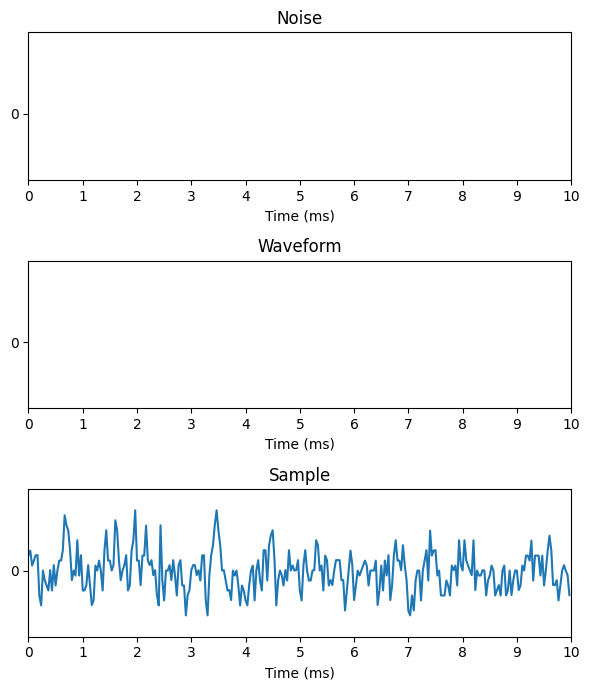

In [19]:
random_seed(7)
for idx in np.random.choice(len(multi_rec), 25):
    sample = multi_rec[idx]
    multi_rec.plot_sample(*sample)

## Load RecordingCrossVal

In [162]:
# Get the recording data
cross_val = data.RecordingCrossVal(
    samples_per_waveform=2, front_buffer=60, end_buffer=60,
    num_wfs_probs=[0, 1], isi_wf_min=3, isi_wf_max=None,
    rec_paths=meta.SI_MOUSE[:], thresh_amp=40, thresh_std=9999,
    sample_size=300, start=0, ms_before=3, ms_after=3, gain_to_uv=0.195,
    device="cpu", dtype=torch.float16, mmap_mode="r",
    as_datasets=False
)
# rec_cross_val.summary()

In [163]:
# Get fold
rec, train, val = cross_val[0]

Val Recording: probe_773592315 - Train: 6773 samples - Val: 1 - Train/Val: 0.0%


In [ ]:
# Plot samples
NUM_SAMPLES = 1
plot.set_dpi(400)
random_seed(2)
##
sample_ind = np.random.choice(range(1, len(train), 2), NUM_SAMPLES)  # Only plot samples with waveforms
for i in sample_ind:
    train.plot_sample(*train[i], alpha_to_wf_dict)

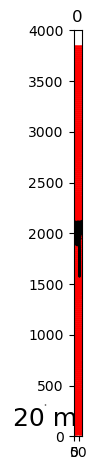

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
def plot_waveform_channels(kilosort_npz_path, thresh_amp, thresh_std,
                           scale_v, scale_h, xlim=None, ylim=None,
                           curation_colors=("red", "black")):
    """
    Plot the mean waveforms (which are defined on different channels) of a unit at their spatial locations
    and color code them based on whether they are curated
    #
    :param kilosort_npz_path:
        spikesort_matlab4.py --> sorted.npz
    :param thresh_amp:
        Minimum amplitude (in arbitrary scaled down units)
    :param thresh_std:
        Minimum standard deviation in amplitude divided by amplitude
    :param scale_v:
        Vertical stretch factor of wf
    :param scale_h:
        Horizontal stretch factor of wf
    :param xlim:
        of plot
        None --> use auto-generated lim
    :param ylim:
        of plot
        None --> use auto-generated lim
    :param curation_colors:
        (failed color, passed color)
    """

    npz = np.load(kilosort_npz_path, allow_pickle=True)
    locations = npz["locations"]
    # Iterate through units
    for i_u, unit in enumerate(npz["units"]):
        # Set up plot
        fig, ax = plt.subplots(1)  # type: Figure, Axes
        ax.set_title(i_u)
        ax.set_aspect("equal")

        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)

        # Get waveform data
        templates = unit["template"].T   # (n_channels, n_samples)
        center_i = templates.shape[1] // 2
        is_curated = (unit["amplitudes"] >= thresh_amp) * (unit["std_norms"] <= thresh_std)  # type: np.ndarray

        # Plot waveforms
        for i, wf in enumerate(templates):
            color = curation_colors[int(is_curated[i])]

            wf *= scale_v
            loc = locations[i]

            x = np.arange(wf.size, dtype=float) - center_i
            x *= scale_h

            x += loc[0]
            wf += loc[1]
            ax.plot(x, wf, color=color)

        # Add scalebar
        fontprops = fm.FontProperties(size=18)
        scalebar = AnchoredSizeBar(ax.transData,
                                   0.195 * thresh_amp, '20 m', 'lower right',
                                   pad=0.1,
                                   color='black',
                                   frameon=False,
                                   size_vertical=1,
                                   fontproperties=fontprops)
        ax.add_artist(scalebar)

        plt.tight_layout()
        plt.show()
        break

plot_waveform_channels(
    kilosort_npz_path="/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592315/spikesort_matlab4/results/sorted.npz",
    thresh_amp=1.2, thresh_std=2,
    scale_v=1, scale_h=1,
    xlim=(0, 80), ylim=(0, 4000),
    curation_colors=("red", "black")
)